# Preliminary

In [1]:
import numpy as np
import math

from scipy.sparse import coo_matrix, linalg

In [2]:
def make_matrix(N):
  A = np.zeros(((N+1)**2, (N+1)**2))
  b = np.zeros((N+1)**2)

  h = 1/N

  for i in range(N+1):
    A[i, i] = 1
    b[i] = 0
  for i in range(N**2+N, (N+1)**2):
    A[i,i] = 1
    b[i] = 0
  for i in range(N + 1, N**2+N, N+1):
    A[i,i] = 1
    b[i] = 0
  for i in range(2* N + 1, (N+1)**2-1, N+1):
    A[i,i] = 1
    b[i] = 0
  for i in range(1, N):
    for j in range(1, N):
      index = j * (N+1) + i
      A[index,index] = 4/h**2
      A[index,j * (N+1) + i-1] = -1/h**2
      A[index,(j-1) * (N+1) + i] = -1/h**2
      A[index,j * (N+1) + i+1] = -1/h**2
      A[index,(j+1) * (N+1) + i] = -1/h**2
      b[index] = 1
  return A, b

In [3]:
N = 4
A, b = make_matrix(N)
sol = np.linalg.solve(A, b)

C:\Users\User\AppData\Local\Temp\ipykernel_5248\2646948043.py:8: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


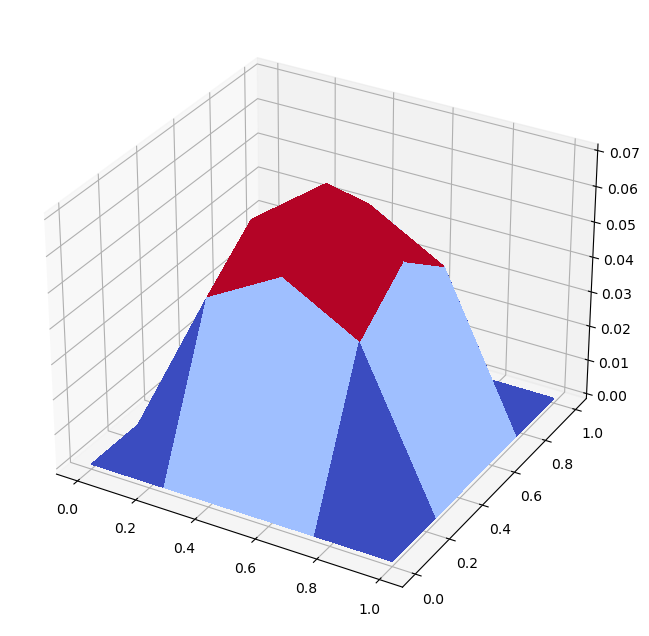

In [4]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

u = sol.reshape((N+1, N+1))

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
ticks= np.linspace(0, 1, N+1)
X, Y = np.meshgrid(ticks, ticks)
surf = ax.plot_surface(X, Y, u, antialiased=False, cmap=cm.coolwarm)

In [5]:
def make_matrix_sparse(N):
  rows = []
  cols = []
  data = []
  b = np.zeros((N+1)**2)

  h = 1/N

  for i in range(N+1):
    rows.append(i)
    cols.append(i)
    data.append(1.0)
    b[i] = 0
  for i in range(N**2+N, (N+1)**2):
    rows.append(i)
    cols.append(i)
    data.append(1.0)
    b[i] = 0
  for i in range(N + 1, N**2+N, N+1):
    rows.append(i)
    cols.append(i)
    data.append(1.0)
    b[i] = 0
  for i in range(2* N + 1, (N+1)**2-1, N+1):
    rows.append(i)
    cols.append(i)
    data.append(1.0)
    b[i] = 0
  for i in range(1, N):
    for j in range(1, N):
      index = j * (N+1) + i
      rows += [index, index, index, index, index]
      cols += [index, j * (N+1) + i-1, (j-1) * (N+1) + i, j * (N+1) + i+1, (j+1) * (N+1) + i]
      data += [4/h**2, -1/h**2, -1/h**2, -1/h**2, -1/h**2]
      b[index] = 1

  rows = np.array(rows)
  cols = np.array(cols)
  data = np.array(data)
  # Note: The error we saw in lectures was in the next line: data, rows, and cols in the wrong order
  A = coo_matrix((data, (rows, cols)), ((N+1)**2, (N+1)**2))
  return A, b

In [6]:
A2, b2 = make_matrix_sparse(4)

In [7]:
# Do a sparse solve
sol2 = linalg.spsolve(A2, b2)

# Check that the two solutions are the same
assert np.allclose(sol, sol2)

C:\Program Files\Anaconda 3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


# Comparing dense and sparse storage

In [11]:
from scipy.sparse import csr_matrix

def coo_memory(A):
    C = coo_matrix(A)
    return C.row.nbytes + C.col.nbytes + C.data.nbytes
    
def csr_memory(A):
    C = csr_matrix(A)
    return C.data.nbytes + C.indices.nbytes + C.indptr.nbytes

memory = np.empty((100, 3))
for i, N in enumerate(range(1, 101)):
    A, b = make_matrix(N)
    memory[i, :] = [A.nbytes, coo_memory(A), csr_memory(A)]

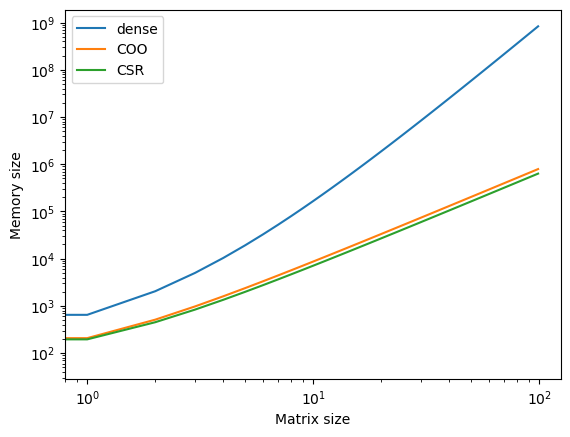

In [27]:
plt.plot(memory[:, 0])
plt.plot(memory[:, 1])
plt.plot(memory[:, 2])
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Matrix size")
plt.ylabel("Memory size")
plt.legend(["dense", "COO", "CSR"])

In [21]:
from timeit import timeit

t_solves = np.empty((100, 2))
for i, N in enumerate(range(1,101)):
    A, b = make_matrix(N)
    A2, b2 = make_matrix_sparse(N)
    t_solves[i, 0] = timeit("numpy.linalg.solve(A, b)", "import numpy; from __main__ import A, b", number=1)
    t_solves[i, 1] = timeit("scipy.sparse.linalg.spsolve(A2, b2)", "import scipy.sparse; from __main__ import A2, b2", number=1)

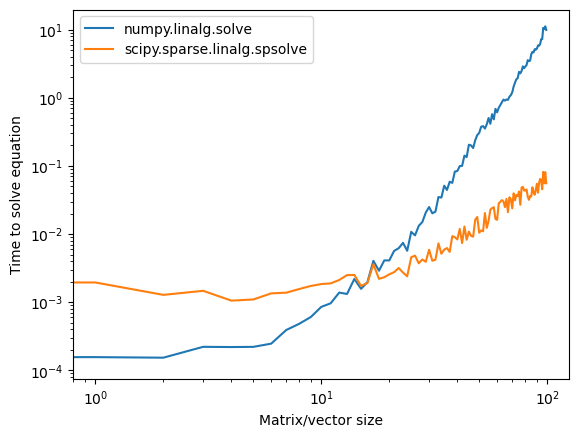

In [28]:
plt.plot(t_solves[:, 0])
plt.plot(t_solves[:, 1])
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Matrix/vector size")
plt.ylabel("Time to solve equation")
plt.legend(["numpy.linalg.solve", "scipy.sparse.linalg.spsolve"])

# When is a sparse matrix worth it?

In [39]:
import random

def rand_zero_mat(M, N):
    matrix = [0]*(N**2 - M)
    for i in range(M):
        matrix.insert(random.randint(0, len(matrix)), random.random())
    matrix = np.matrix(matrix).reshape((N, N))
    return matrix

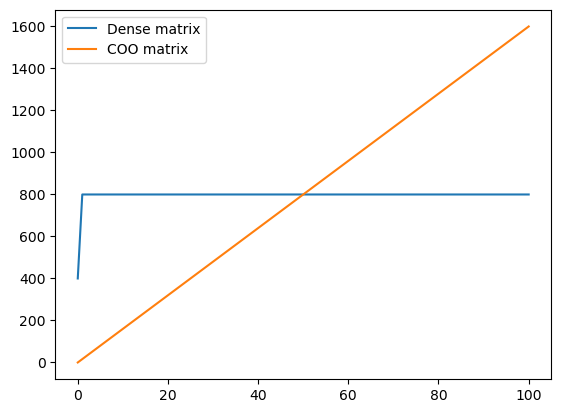

In [40]:
dense_mat_mem = [rand_zero_mat(i, 10).nbytes for i in range(101)]
coo_mat_mem = [coo_memory(rand_zero_mat(i, 10)) for i in range(101)]

plt.plot(range(101), dense_mat_mem)
plt.plot(range(101), coo_mat_mem)
plt.legend(["Dense matrix", "COO matrix"])

In [41]:
print(dense_mat_mem[50], coo_mat_mem[50])

800 800


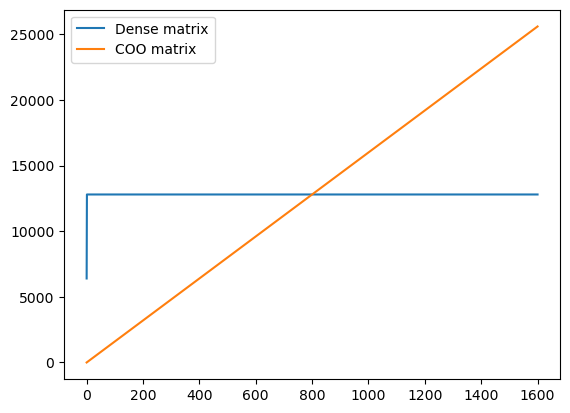

In [43]:
dense_mat_mem = [rand_zero_mat(i, 40).nbytes for i in range(1601)]
coo_mat_mem = [coo_memory(rand_zero_mat(i, 40)) for i in range(1601)]

plt.plot(range(1601), dense_mat_mem)
plt.plot(range(1601), coo_mat_mem)
plt.legend(["Dense matrix", "COO matrix"])

In [44]:
print(dense_mat_mem[800], coo_mat_mem[800])

12800 12800
